Notebook presenting basic implementation of Gillespie's direct algorithm for simulating an SIR process on a network.

# Import libraries

In [1]:
%matplotlib inline

import numpy as np
import networkx as nx
import matplotlib.pylab as plt


#from numpy.random import seed, rand
from numpy.random import Generator, PCG64

In [2]:
#--- Set up PRNG: ---
seed= 42                     # Set seed of PRNG state 
rg = Generator(PCG64(seed))  # Initialize bit generator (here PCG64) with seed
print(f"PRNG: {rg.bit_generator}")

PRNG: <numpy.random._pcg64.PCG64 object at 0x7fceb7f65f60>


# SIR on network

## Define functions

In [3]:
##################################################################################################

def calculate_node_propensities(G, beta, mu):
    
    N      = len(G)
    Lambda = 0
        
    for i in range(N):
        #--- If node is susceptible calculate total propensity for infection: ---
        if G.nodes[i]['state'] == 0:
            # Get i's neighbors:
            neighbor_states = [G.nodes[j]['state'] for j in G.neighbors(i)] 

            # Total node rate from number of neighbors that are infectious:
            lambda_i = beta * np.sum([state==1 for state in neighbor_states])
            
            # Set node rate:
            G.nodes[i]['lambda'] = lambda_i
            
            # Add to total rate:
            Lambda += lambda_i
            
        #--- If node is infectious set propensity to mu: ---
        elif G.nodes[i]['state'] == 1:
            # Set node propensity:
            G.nodes[i]['lambda'] = mu                   
            
            # Add to total propensity:
            Lambda += mu
    
    return(Lambda)

##################################################################################################
##################################################################################################

def direct_event_draw(Lambda, G):
    u1, u2 = rg.random(2)

    # Draw waiting time and increment time:
    tau = - np.log(1. - u1) / Lambda # rg.random generates u ~ U([0,1)), so use 1 - u to avoid log(0)

    #--- Select reaction: ---
    target_sum = u2 * Lambda
    sum_i = 0

    for i,attributes in G.nodes(data=True): 
        sum_i += attributes['lambda']

        if sum_i >= target_sum:
            break
    
    return(tau, i)

##################################################################################################
##################################################################################################

def update_states(G, X, Lambda, i):
    state_before = G.nodes[i]['state']

    #--- If state_before was S, update to I: ---
    if state_before==0:             
        # Update state counts: 
        X[0] -= 1
        X[1] += 1

        # Update state of node in graph (S -> I): 
        G.nodes[i]['state'] = 1

        # Update i's propensity:
        Lambda += -G.nodes[i]['lambda'] + mu
        G.nodes[i]['lambda'] = mu

        # Update propensities of i's neighbors:
        susceptible_neighbors = np.array([j for j in G.neighbors(i) if G.nodes[j]['state']==0])

        if len(susceptible_neighbors)>0:
            for j in susceptible_neighbors:
                G.nodes[j]['lambda'] += beta
                Lambda += beta

    #--- Else, if state_before was I, update to R: ---
    else: # (Note that this is a simple else statement since state_before is either S or I)
        # Update state counts: 
        X[1] -= 1
        X[2] += 1

        # Update state of node in graph: 
        G.nodes[i]['state'] = 2

        # Update i's propensity:
        G.nodes[i]['lambda'] = 0.
        Lambda -= mu

        # Update propensities of i's neighbors:
        susceptible_neighbors = np.array([j for j in G.neighbors(i) if G.nodes[j]['state']==0])

        if len(susceptible_neighbors)>0:
            for j in susceptible_neighbors:
                G.nodes[j]['lambda'] -= beta
                Lambda -= beta

    return(X, Lambda)

##################################################################################################
##################################################################################################

def direct_method_SIR_graph_linear(G, beta, mu, T):
    
    #--- Initialization: ---
    node_states = nx.get_node_attributes(G, 'state')
    
    N = len(node_states)
    S = sum(X==0 for X in node_states.values())
    I = sum(X==1 for X in node_states.values())
    R = N - S - I 

    # Calculate and store node propensities:
    Lambda = calculate_node_propensities(G, beta, mu)    

    # Set initial time t = 0:
    t = 0

    # Vector to save temporal evolution of state numbers over time: 
    X_t = [] 
    X_t.append([t, S, I, R])
    
    #--- Keep drawing events until t >= T: ---
    while t < T:
        # Check for Lambda == 0 (no more reactions can happen):
        if np.isclose(Lambda, 0.):
            # Save final state and break loop:
            X_t.append([T, S, I, R])
            break
        
        #===== Direct event sampling step: =====
        tau, i = direct_event_draw(Lambda, G) 
        
        t += tau
                
        #===== Update states: =====
        [S, I, R], Lambda = update_states(G, [S,I,R], Lambda, i)
        
        #--- Save current state numbers to X_t: ---
        X_t.append([t, S, I, R])
        
    return(np.array(X_t).transpose()) #, states_t)

##################################################################################################


## $k$-regular graph 

## Simulate and plot

### Small number of individual realizations

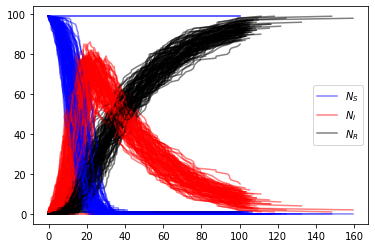

In [4]:
rg = Generator(PCG64(seed))  # Initialize bit generator (here PCG64) with seed

#--- Simulation parameters: ---
beta = 0.1   # Infection rate
mu     = 0.03  # Recovery rate
k      = 5     # Degree of nodes
N      = 100   # Number of nodes
T      = 100  # Simulation duration

number_of_simulations = 100

G0 = nx.random_regular_graph(d=k, n=N)

X_array = []

for q in range(number_of_simulations):
    G = G0.copy()

    I_nodes = [0]
    R_nodes = []

    states = np.zeros(N, dtype=int)
    states[I_nodes] = 1
    states[R_nodes] = 2

    nx.set_node_attributes(G, 'state', 0)
    for i,state in enumerate(states):
        G.nodes[i]['state'] = state

    X_t = direct_method_SIR_graph_linear(G, beta, mu, T)

    X_array.append(X_t)

#=============================================================================================
# Plot:
#=============================================================================================
colors = ['b','r','k']
legends = [r'$N_S$',r'$N_I$',r'$N_R$']

fig = plt.figure()
ax  = plt.subplot()

for X_t in X_array:
    [ax.plot(X_t[0],X_,c=c_,alpha=0.5) for X_,c_ in zip(X_t[1:],colors)]

ax.legend(legends)

### 

## Test speed

In [5]:
G = G0.copy()

nx.set_node_attributes(G, 'state', 0)
for i,state in enumerate(states):
    G.nodes[i]['state'] = state       
    
rg = Generator(PCG64(seed))  # Initialize bit generator (here PCG64) with seed

In [6]:
%%timeit

G1 = G.copy()
direct_method_SIR_graph_linear(G1, beta, mu, T)

18.8 ms ± 4.38 ms per loop (mean ± std. dev. of 7 runs, 100 loops each)


## ER graph 

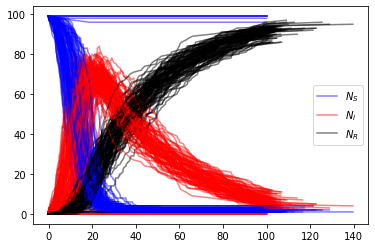

In [7]:
#--- Simulation parameters: ---
beta = 0.1   # Infection rate
mu     = 0.03  # Recovery rate
k      = 5     # Mean degree
N      = 100   # Number of nodes
T      = 100   # Simulation duration

number_of_simulations = 100

G0 = nx.gnm_random_graph(n=N, m=k*N/2)

X_array = []

for q in range(number_of_simulations):
    G = G0.copy()

    I_nodes = [0]
    R_nodes = []

    states = np.zeros(N, dtype=int)
    states[I_nodes] = 1
    states[R_nodes] = 2

    nx.set_node_attributes(G, 'state', 0)
    for i,state in enumerate(states):
        G.nodes[i]['state'] = state

    X_t = direct_method_SIR_graph_linear(G, beta, mu, T)

    X_array.append(X_t)
    
#=============================================================================================
# Plot:
#=============================================================================================
colors  = ['b','r','k']
legends = [r'$N_S$',r'$N_I$',r'$N_R$']

fig = plt.figure()
ax  = plt.subplot()

for X_t in X_array:
    [ax.plot(X_t[0],X_,c=c_,alpha=0.5) for X_,c_ in zip(X_t[1:],colors)]
    
ax.legend(legends)

##  BA graph

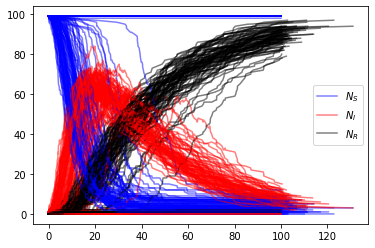

In [8]:
#--- Simulation parameters: ---
beta   = 0.1   # Infection rate
mu     = 0.03  # Recovery rate
k      = 4     # Mean degree
N      = 100   # Number of nodes
T      = 100   # Simulation duration

number_of_simulations = 100

G0 = nx.barabasi_albert_graph(n=N, m=int(k/2))

X_array = []

for q in range(number_of_simulations):
    G = G0.copy()

    I_nodes = [0]
    R_nodes = []

    states = np.zeros(N, dtype=int)
    states[I_nodes] = 1
    states[R_nodes] = 2

    nx.set_node_attributes(G, 'state', 0)
    for i,state in enumerate(states):
        G.nodes[i]['state'] = state

    X_t = direct_method_SIR_graph_linear(G, beta, mu, T)

    X_array.append(X_t)

#=============================================================================================
# Plot:
#=============================================================================================
colors = ['b','r','k']
legends = [r'$N_S$',r'$N_I$',r'$N_R$']

fig = plt.figure()
ax  = plt.subplot()

for X_t in X_array:
    [ax.plot(X_t[0],X_,c=c_,alpha=0.5) for X_,c_ in zip(X_t[1:],colors)]

ax.legend(legends)